In [1]:
import numpy as np, matplotlib.pyplot as plt, time, copy, random, math
#%load_ext line_profiler
from ortools.graph import pywrapgraph
directory = '../data/'
file_paths = ['a_example.txt', 'b_read_on.txt', 'c_incunabula.txt','d_tough_choices.txt', 'e_so_many_books.txt', 'f_libraries_of_the_world.txt']

### Classes

In [2]:
class Library():
    def __init__(self,index,N,T,M):
        self.id = index
        self.size  = N
        self.signup_time = T
        self.books_per_day = M
        self.book_ids = set()
        
    def add_book(self,book):
        self.book_ids.add(book)
        
    def remove_book(self,book):
        self.book_ids.remove(book)
        
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

### Utils

In [3]:
def process_file(filePath):
    with open(directory+filePath,'r') as file:
        content = file.read().split('\n')[:-1];
        B,L,D = content[0].split()
        B,L,D = int(B),int(L),int(D)
    book_libraries = [set() for i in range(B)]
    bookValues = [int(n) for n in content[1].split()]
    libraries = []
    for i in range(L):
        N,T,M = content[2+2*i].split()
        N,T,M=int(N),int(T),int(M)
        book_ids = set(int(id) for id in content[2+2*i+1].split())
        library = Library(i,N,T,M)
        for book_id in book_ids:
            book_libraries[book_id].add(i)
            library.add_book(book_id)
        libraries.append(library)
    return ((B,L,D), bookValues,book_libraries, libraries)

In [4]:
def check_solution(D, libraries):
    days = 0
    prev_books = set()
    lib_ids = [lib.id for lib in libraries]
    assert(len(lib_ids) == len(set(lib_ids)))
    for library in libraries:
        days+=library.signup_time
        if len(library.book_ids) > (D-days)*library.books_per_day:
            print("what", len(library.book_ids), (D-days)*library.books_per_day)
        assert(len(library.book_ids) == len(set(library.book_ids)))
        assert(not any([(book in prev_books) for book in library.book_ids]))
        prev_books.update(library.book_ids)
    assert(days < D)
    
def score_solution(libraries, book_values):
    score=0
    for library in libraries:
        for book_id in library.book_ids:
            score+= book_values[book_id]
    return score

In [5]:
class ProblemSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B,L,D
        self.book_values = book_values
        self.libraries = libraries
        self.book_libraries = copy.deepcopy(book_libraries)
        
    def book_score(self, book):
        return self.book_values[book]
    
    def get_n_best_books(self,lib, n):
        return sorted(lib.book_ids,key=self.book_score, reverse=True)[:n]
        
    def get_solution(self,selected_lib_ids=None):
        if not selected_lib_ids:
            selected_lib_ids = self.get_individual()
        day = 0
        selected_libraries = [copy.deepcopy(self.libraries[i]) for i in selected_lib_ids]
        it=0;
        already_scanned_books = set()
        while it < len(selected_libraries):
            next_library = selected_libraries[it]
            day+=next_library.signup_time
            if day>=self.D:
                break
            next_library.book_ids = next_library.book_ids - already_scanned_books
            next_library.book_ids = sorted(next_library.book_ids,key=self.book_score, reverse=True)[:(self.D-day)*next_library.books_per_day]
            already_scanned_books.update(next_library.book_ids)
            it+=1
        return selected_libraries[:it]
    
    def get_individual(self):
        pass

In [6]:
class HeurysticSolver(ProblemSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores/lib.signup_time
    
    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        lib_ids.sort(key = self.library_score, reverse= True)
        day = 0
        chosen = []
        for i in range(len(lib_ids)):
            if day + self.libraries[lib_ids[i]].signup_time >= self.D:
                continue  
            day+=self.libraries[lib_ids[i]].signup_time
            chosen.append(lib_ids[i])
        return tuple(chosen)

In [7]:
class PowerSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores/lib.signup_time**(1+lib.signup_time/self.D)

In [8]:
class SimpleScoreVarianceSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores/book_variance

In [9]:
class SquareScoreVarianceSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores**2/(lib.signup_time*lib.signup_time*math.sqrt(book_variance))

In [10]:
class BookNumbersSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001,np.var(best_scores))
        return sum_of_best_book_scores**2/(book_variance*len(n_best_books)*lib.signup_time)

In [11]:
class ScoreSquareSolver(HeurysticSolver):
    def library_score(self,lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores**2/lib.signup_time

In [12]:
class BookCountSolver(HeurysticSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7*len(self.book_libraries[book])

In [13]:
class BookCountPowerSolver(PowerSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7*len(self.book_libraries[book])

In [14]:
sum_score = 0
solvers_cls = [HeurysticSolver, PowerSolver, SimpleScoreVarianceSolver, SquareScoreVarianceSolver, BookNumbersSolver, ScoreSquareSolver, BookCountSolver, BookCountPowerSolver]
for file_path in file_paths:
    (B,L,D),book_values,book_counts, libraries = process_file(file_path)
    solvers = [cl(B,L,D,book_values,book_counts, libraries) for cl in solvers_cls]
    %time solutions = [solver.get_solution() for solver in solvers]
#     print(list(lib.id for lib in solutions[0]))
    [check_solution(D, solution) for solution in solutions]
    scores = [score_solution(solution, book_values) for solution in solutions]
    print(scores)
    score = max(scores)
    print(score)
    sum_score+=score
print("SUM",sum_score)

CPU times: user 819 µs, sys: 445 µs, total: 1.26 ms
Wall time: 1.18 ms
[21, 21, 21, 21, 21, 21, 21, 21]
21
CPU times: user 856 ms, sys: 0 ns, total: 856 ms
Wall time: 856 ms
[5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900, 5822900]
5822900
CPU times: user 2.29 s, sys: 32.6 ms, total: 2.32 s
Wall time: 2.28 s
[5645747, 5644690, 1191778, 5632921, 5309433, 5530843, 5645747, 5644690]
5645747
CPU times: user 8.51 s, sys: 23.6 ms, total: 8.54 s
Wall time: 8.53 s
[4815395, 4815395, 4815395, 4815395, 4815395, 4815395, 4815395, 4815395]
4815395
CPU times: user 2.56 s, sys: 24.5 ms, total: 2.59 s
Wall time: 2.57 s
[5020495, 5023616, 774717, 4791445, 2797585, 4741433, 5021339, 5024351]
5024351
CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 2.45 s
[5240161, 5238624, 1326571, 5211764, 4111186, 5083231, 5240157, 5238622]
5240161
SUM 26548575


In [15]:
class RandomSolver(ProblemSolver):
    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        random.shuffle(lib_ids)
        day = 0
        for i in range(len(lib_ids)):
            day += self.libraries[lib_ids[i]].signup_time
            if day >= self.D:
                return tuple(lib_ids[:i])
        return tuple(lib_ids)

In [16]:
class GreedyIntervalSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B, L, D
        self.book_values = book_values
        self.libraries = copy.deepcopy(libraries)
        self.book_libraries = copy.deepcopy(book_libraries)

    def book_score(self, book_id):
        return self.book_values[book_id] - 0.7 * len(self.book_libraries[book_id])

    def get_n_best_books(self, lib, n):
        return sorted(lib.book_ids, key=self.book_score, reverse=True)[:n]

    def library_score(self, lib_id, current_day):
        lib = self.libraries[lib_id]
        delta_time = self.D - current_day - lib.signup_time
        n_best_books = self.get_n_best_books(lib, min(delta_time * lib.books_per_day, len(lib.book_ids)))
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        sum_of_best_book_scores /= lib.signup_time
        return sum_of_best_book_scores  # / lib.signup_time ** (1 + lib.signup_time / self.D)

    def get_solution(self):
        remaining_libraries = set(lib.id for lib in self.libraries)
        day = 0
        chosen_libraries = []
        it = 0
        interval = 25#max(1, int(self.L/1000))
        while len(remaining_libraries) > 0:
            if it%interval == 0:
                library_scores = [(self.library_score(lib_id, day), lib_id) for lib_id in remaining_libraries]
            it += 1
            max_el = max(library_scores, key=lambda x: x[0])
            library_scores.remove(max_el)
            score, lib_id = max_el
            remaining_libraries.remove(lib_id)
            library = self.libraries[lib_id]
            if day + library.signup_time >= self.D:
                break
            day += library.signup_time
            books_to_take = (self.D - day) * library.books_per_day
            sorted_books = sorted(library.book_ids, key=self.book_score, reverse=True)
            for book_id in sorted_books[:books_to_take]:
                for lib_id in self.book_libraries[book_id]:
                    if lib_id != library.id:
                        self.libraries[lib_id].remove_book(book_id)

            for book_id in sorted_books[books_to_take:]:
                self.book_libraries[book_id].remove(library.id)

            library.book_ids = sorted_books[:books_to_take]
            chosen_libraries.append(library)
        return chosen_libraries

    def get_individual_from_solution(self, solution):
        return tuple([lib.id for lib in solution])

In [17]:
class GeneticSolver(ProblemSolver):
    def __init__(self, B, L, D, book_values,book_libraries, libraries, pop_size = 20, p_mutate = 0.5, surv_rate = 0.2, tournament_size = 3):
        super().__init__(B, L, D, book_values,book_libraries, libraries)
        num = 1
        mult = len(libraries)
        while num < pop_size and mult != 1:
            num*=mult
            mult-=1
        self.pop_size = min(pop_size,num)
        self.p_mutate = p_mutate
        self.tournament_size = min(self.pop_size,tournament_size)
        self.surv_rate = surv_rate
        
        self.indiv_scores = dict()
        self.lib_ids = [i for i in range(len(libraries))]
        self.lib_scores = [self.lib_score(lib) for lib in self.libraries]
        
    def lib_score(self, lib):
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time
        
        
    def mutate(self, individual):
        new_one = list(individual)
        if random.random() <=0.5:
            #internal mutation
            length = len(new_one)
            for i in range(4):
                a,b = random.sample(range(length), 2)
                new_one[a],new_one[b] =new_one[b],new_one[a]
            return tuple(individual)                  
        else:
            #exxternal mutation
            additional = random.choices(self.lib_ids, k=4, weights = self.lib_scores)
            unique = set(additional)
            for un in unique:
                new_one.insert(random.randrange(0,len(new_one)), un)
            return self.cut(new_one)
            
    def cut(self, new_one):
        day =0;
        chosen = set()
        solution = []
        for i in range(len(new_one)):
            if new_one[i] not in chosen:
                day+=self.libraries[new_one[i]].signup_time
                if day >= self.D:
                    continue
                solution.append(new_one[i])
                chosen.add(new_one[i])
        return tuple(solution)
    
    def crossover(self,indiv_1, indiv_2):
        set1 = set(indiv_1)
        set2 = set(indiv_2)
        common = set1.intersection(set2)
        maxLen = max(len(indiv_1), len(indiv_2))
        child1,child2,=[-1]*maxLen,[-1]*maxLen
        only1,only2 = [],[]
        for i in range(len(indiv_1)):
            if indiv_1[i] in common:
                child1[i] =  indiv_1[i]
            else:
                only1.append(indiv_1[i])
        for i in range(len(indiv_2)):
            if indiv_2[i] in common:
                child2[i] = indiv_2[i]
            else:
                only2.append(indiv_2[i])
        for i in range(maxLen):
            if child1[i] == -1 and len(only2) > 0:
                child1[i] = only2.pop(0)
            if child2[i] == -1 and len(only1) > 0:
                child2[i] = only1.pop(0)
        child1 = [i for i in child1 if i !=-1]
        child2 = [i for i in child2 if i !=-1]
                        
        child1 = self.cut(child1)
        child2 = self.cut(child2)
        if random.random()<=self.p_mutate:
            child1 = self.mutate(child1)
        if random.random()<=self.p_mutate:
            child2 = self.mutate(child2)
        return child1, child2
    
    def tournament(self, indivs):
        return max(indivs, key = self.indiv_scores.get);
    
    def select_survivals(self, population):
        k = int(5*self.pop_size*self.surv_rate)
        weights = [self.indiv_scores[indiv] for indiv in population]
        chosen = []
        already_chosen = set()
        desired = int(self.pop_size*self.surv_rate)
        while len(already_chosen) < desired:
            candidates = random.choices(population, k = k, weights = weights)
            for cand in candidates:
                if cand not in already_chosen:
                    chosen.append(cand)
                    already_chosen.add(cand)
        return chosen
    
    def get_initial_population(self):
        solvers_cls = [HeurysticSolver, PowerSolver, SimpleScoreVarianceSolver, SquareScoreVarianceSolver, BookNumbersSolver, ScoreSquareSolver, BookCountSolver, BookCountPowerSolver]
        solvers = [cl(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries) for cl in solvers_cls]
        population = [solver.get_individual() for solver in solvers]
        greedyIntervalSolver = GreedyIntervalSolver(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries)
        greedyIntervalSolution = greedyIntervalSolver.get_solution();
        gis_individual = greedyIntervalSolver.get_individual_from_solution(greedyIntervalSolution)
        population.append(gis_individual)
        self.indiv_scores[gis_individual] = score_solution(greedyIntervalSolution, self.book_values)
        randomSolver = RandomSolver(self.B,self.L,self.D,self.book_values,self.book_libraries, self.libraries)
        while len(population) < self.pop_size:
            population.append(randomSolver.get_individual())
        return population
    
    def get_individual(self):
        population = self.get_initial_population()
        for indiv in population:
            sol = self.get_solution(indiv)
            self.indiv_scores[indiv] = score_solution(sol, self.book_values)
        startTime = time.time()
        progress = []
        cur_state = []
        times = []
        while(True):
            progress.append(max(self.indiv_scores.values()))
            cur_state.append(max([self.indiv_scores[pop] for pop in population]))
            times.append(time.time() - startTime)
            if(time.time() - startTime > 290):
                break
            new_population = [ self.tournament(random.sample(population, self.tournament_size)) for i in range(int(self.pop_size*self.surv_rate))]
            while len(new_population) < self.pop_size:
                indiv_1 = self.tournament(random.sample(population, self.tournament_size))
                indiv_2 = self.tournament(random.sample(population, self.tournament_size))
                if random.random()<= 0.5:
                    new_child1 = self.mutate(indiv_1)
                    new_child2 = self.mutate(indiv_2)
                else:
                    new_child1, new_child2 = self.crossover(indiv_1, indiv_2)
                if new_child1 not in self.indiv_scores:
                    self.indiv_scores[new_child1] = score_solution(self.get_solution(new_child1), book_values)
                if new_child2 not in self.indiv_scores:
                    self.indiv_scores[new_child2] = score_solution(self.get_solution(new_child2), book_values)
                new_population.append(new_child1)
                new_population.append(new_child2)
            population = tuple(new_population)
        plt.title("Progress min,max"+str(min(progress))+", "+str(max(progress)))
        plt.scatter(times,progress, color="blue", label = "progress", alpha=0.5)
        plt.scatter(times,cur_state, color="red", label = "cur_state", alpha=0.5)
        plt.show()
        return max(self.indiv_scores, key = self.indiv_scores.get)
              

In [18]:
# sum_score =0
# for file_path in file_paths[:2]:
#     (B, L, D), book_values,book_counts, libraries = process_file(file_path)
#     solver = GeneticSolver(B, L, D, book_values, book_counts, libraries, 20)
#     solution = solver.get_solution()
#     #print(solution)
#     check_solution(D, solution)
#     score = score_solution(solution, book_values)
#     print("S: ",score)
#     sum_score += score

# print(sum_score)

In [19]:
# sum_score =0
# for file_path in file_paths:
#     (B, L, D), book_values,book_counts, libraries = process_file(file_path)
#     print(sum(book_values))

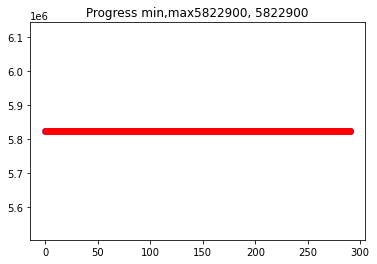

 xd: 5822900
optimal flow:  58229
Score 5822900


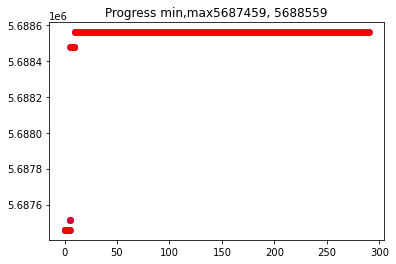

 xd: 5688559
optimal flow:  18430
Score 5688559


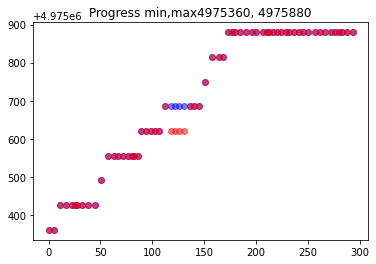

 xd: 4975880
optimal flow:  76552
Score 4975880


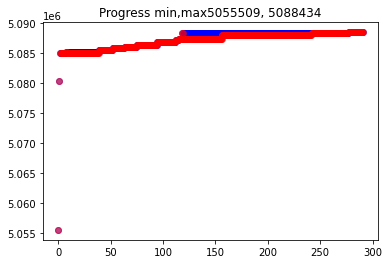

 xd: 5088434
optimal flow:  28898
Score 5215025


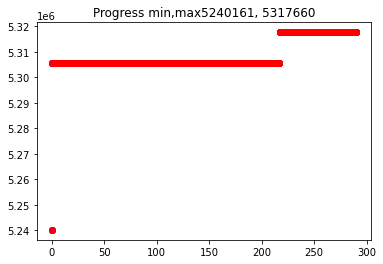

 xd: 5317660
optimal flow:  13025
Score 5317660


In [20]:
def generate_book_to_node_assignment(number_of_libraries, all_book_ids):
    book_to_node = dict()
    node_to_book = dict()
    counter = 1
    for book_id in all_book_ids:
        node_nr = number_of_libraries + counter
        book_to_node[book_id] = node_nr
        node_to_book[node_nr] = book_id
        counter+=1
    return book_to_node,node_to_book
        
def lib_to_node(lib_id):
    return lib_id+1

def node_to_lib(node):
    return node -1

for file_path in file_paths[1:]:
    (B, L, D), book_values, book_counts, libraries = process_file(file_path)
    libraries_backup = copy.deepcopy(libraries)
    solver = GeneticSolver(B, L, D, book_values, book_counts, libraries, 20)
    indiv = solver.get_individual()
    check_solution(D, solver.get_solution(selected_lib_ids=indiv))
    score3 = score_solution(solver.get_solution(selected_lib_ids=indiv), book_values)
    print(" xd:",score3)
    libraries = libraries_backup
    #nodes 0 - init
    # 1- len(indiv) - library
    # len(indiv)+1 - len(indiv) + len(all_books)
    #len(indiv) + len(all_books)
    
    all_book_ids = set()
    for lib_id in indiv:
        all_book_ids.update(libraries[lib_id].book_ids)
    book_to_node,node_to_book = generate_book_to_node_assignment(len(indiv),all_book_ids)
    
    start_nodes = []
    end_nodes = []
    capacities = []
    unit_costs = []
    
    source = 0
    sink = len(indiv) + len(all_book_ids)+1
    day = 0
    
    #from source to lib
    for i in range(len(indiv)):
        day += libraries[indiv[i]].signup_time
        start_nodes.append(source)
        end_nodes.append(lib_to_node(i))
        capacities.append((D-day)*libraries[indiv[i]].books_per_day)
        unit_costs.append(0)
        
    # from lib to book
    for i in range(len(indiv)):
        for book_id in libraries[indiv[i]].book_ids:
            start_nodes.append(lib_to_node(i))
            end_nodes.append(book_to_node[book_id])
            capacities.append(1)
            unit_costs.append(0)
    #from book to sink
    for book_id in all_book_ids:
        start_nodes.append(book_to_node[book_id])
        end_nodes.append(sink)
        capacities.append(1)
        unit_costs.append(-book_values[book_id])
        
    max_flow = pywrapgraph.SimpleMaxFlow()
  # Add each arc.
    for i in range(0, len(start_nodes)):
        max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])
    max_flow.Solve(0, sink)
    if max_flow.Solve(0, sink) != max_flow.OPTIMAL:
            raise Exception("shit", max_flow.OptimalFlow())
    optimal_flow = max_flow.OptimalFlow()
#     print("optimal flow: ", optimal_flow)
            
    supplies = [0 for i in range(sink+1)]
    supplies[0] = optimal_flow
    supplies[-1] = -optimal_flow
    
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()

    # Add each arc.
    for i in range(0, len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],
                                                    capacities[i], unit_costs[i])
    for i in range(0, len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    
    if min_cost_flow.Solve() != min_cost_flow.OPTIMAL:
        print("min cost shit")
    solution = []
    for lib_id in indiv:
        lib2 = copy.deepcopy(libraries[lib_id])
        lib2.book_ids = set()
        solution.append(lib2)
    for i in range(min_cost_flow.NumArcs()):
        from_node = min_cost_flow.Tail(i)
        to_node = min_cost_flow.Head(i)
        flow = min_cost_flow.Flow(i)
        cost = min_cost_flow.UnitCost(i)
        if lib_to_node(0)<= from_node <= lib_to_node(len(indiv) -1) and flow == 1:
            lib_index = node_to_lib(from_node)
            book_id = node_to_book[to_node]
            solution[lib_index].book_ids.add(book_id)

    check_solution(D, solution)
    score = score_solution(solution, book_values)
    print("Score", score)
    

TODO Janek try to add hillclimbing to previous algorithm
below is hillclimb sourcecode.

In [21]:
class MutationHillClimbingSolver(ProblemSolver):
    def __init__(self, B, L, D, book_values,book_libraries, libraries, indiv_scores, neighbourhood_size = 10):
        super().__init__(B, L, D, book_values,book_libraries, libraries)
        self.neighbourhood_size = neighbourhood_size
        self.indiv_scores = indiv_scores
        self.lib_ids = [i for i in range(len(libraries))]
        self.lib_scores = [self.lib_score(lib) for lib in self.libraries]
        
    def lib_score(self, lib):
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time*lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time
        
    def mutate(self, individual):
        new_one = list(individual)
        if random.random() <=0.5:
            #internal mutation
            length = len(new_one)
            for i in range(4):
                a,b = random.sample(range(length), 2)
                new_one[a],new_one[b] =new_one[b],new_one[a]
            return tuple(individual)                  
        else:
            #exxternal mutation
            additional = random.choices(self.lib_ids, k=4, weights = self.lib_scores)
            unique = set(additional)
            for un in unique:
                new_one.insert(random.randrange(0,len(new_one)), un)
            return self.cut(new_one)
            
    def cut(self, new_one):
        day =0;
        chosen = set()
        solution = []
        for i in range(len(new_one)):
            if new_one[i] not in chosen:
                day+=self.libraries[new_one[i]].signup_time
                if day >= self.D:
                    continue
                solution.append(new_one[i])
                chosen.add(new_one[i])
        return tuple(solution)
    
    def get_individual(self, start_individual):
        cur_best = copy.copy(start_individual)
        cur_best_score = self.indiv_scores[cur_best]
        start_time = time.time()
        progress = []
        cur_state = []
        times = []
        while time.time() - start_time <= 100:
            neighbourhood = []
            n_scores = []
            for i in range(self.neighbourhood_size):
                new_one = self.mutate(cur_best)
                if new_one not in self.indiv_scores:
                    new_solution = self.get_solution(new_one)
                    new_score = score_solution(new_solution, self.book_values)
                    self.indiv_scores[new_one] = new_score
                else:
                    new_score = self.indiv_scores[new_one]
                neighbourhood.append(new_one)
                n_scores.append(new_score)
            new_max_score = max(n_scores)
            new_max_score_index = n_scores.index(new_max_score)
            if new_max_score > cur_best_score:
                cur_best = neighbourhood[new_max_score_index]
                cur_best_score = new_max_score
            progress.append(cur_best_score)
            cur_state.append(new_max_score)
            times.append(time.time() - start_time)
        plt.title("Progress min,max"+str(min(progress))+", "+str(max(progress)))
        plt.scatter(times,progress, color="blue", label = "progress", alpha=0.5)
        plt.scatter(times,cur_state, color="red", label = "cur_state", alpha=0.5)
        plt.show()
        return cur_best

In [22]:
#Example climber call

In [23]:
climber = MutationHillClimbingSolver(B,L,D,book_values,book_counts, libraries, genetic_solver.indiv_scores)
climbed_indiv = climber.get_individual(indiv)
climbed_solution = climber.get_solution(climbed_indiv)
check_solution(D,climbed_solution)
climbed_score = score_solution(climbed_solution, book_values)

NameError: name 'genetic_solver' is not defined